In [44]:
from sklearn.metrics import r2_score
from sklearn import model_selection
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [45]:
def SAVE_TO_FILE(df_, modelName,path):
    df_.to_csv(path + 'mmingalov_kaggle_math_exam(' + modelName + ').csv', index=False)

In [46]:
# интерквартильный размах
def IQ_processing(df_, list_):
    for i in list_:
        c = i
        IQP = IQ_param_get(df_,c)
        print(c,IQP)
        df_[(df_[c] < IQP['low_border']) | (df_[c]> IQP['high_border'])]
        df_.loc[df_[c] > IQP['high_border'], c] = IQP['median']
        df_.loc[df_[c] < IQP['low_border'], c] = IQP['median']
        print('count after procesing:',df_[(df_[c] < IQP['low_border']) | (df_[c]> IQP['high_border'])][c].count())
# Обработка выбросов -- медианы для значений за пределами 
def IQ_param_get(df_, column_):
    m = df_[column_].median()
    c = column_
    IQ=df_[c].describe()['75%']-df_[c].describe()['25%']
    
    low_border=df_[c].describe()['25%']-IQ*1.5
    
    high_border=df_[c].describe()['75%']+IQ*1.5
 
    count1 = df_[(df_[c] < low_border) | (df_[c]> high_border)][c].count()
    
    result = {
        'IQ':IQ,
        'low_border':low_border,
        'high_border':high_border,
        'count': count1,
        'median': m
    }
    return result

In [47]:
class Node: 
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        return np.mean(self.labels)
    
    def predict_dispersion(self):
        return np.var(self.labels, ddof=1)
    
    def predict_std(self):
        return np.std(self.labels, ddof=1)

In [48]:
class Tree:

    def __init__(self, max_depth=10, max_leaf_qty=1024):
        self.max_depth = max_depth
        self.max_leaf_qty = max_leaf_qty
        self.tree = None

    # дисперсия значений
    def dispersion(self, labels):
        return np.var(labels, ddof=1)
    
    # ср.кв.откл. значений
    def standard_deviation(self, labels):
        return np.std(labels, ddof=1)

    # качество
    def quality(self, left_labels, right_labels, current_dispersion):
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        return current_dispersion - p * self.dispersion(left_labels) - (1 - p) * self.dispersion(right_labels)

    # Ветвление в узле
    def split(self, data, labels, index, t):
    
        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)
        
        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]
        
        return true_data, false_data, true_labels, false_labels

    # Определение наилучшего разбиения
    def find_best_split(self, data, labels):
    
        #  минимально допустимое количество объектов в узле
        min_leaf = 100

        current_dispersion = self.dispersion(labels)

        best_quality = 0
        best_t = None
        best_index = None
    
        n_features = data.shape[1]
    
        for idx in range(n_features):
          # берем уникальные значения
            t_values = np.unique([item[idx] for item in data])
      
            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, idx, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < min_leaf or len(false_data) < min_leaf:
                    continue

                current_quality = self.quality(true_labels, false_labels, current_dispersion)
        
                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, idx

        return best_quality, best_t, best_index

    # Построение дерева с помощью рекурсивной функции

    def build_tree(self, data, labels, tree_depth, max_depth=5, max_leaf_qty=32, min_per_leaf=5, classes_per_leaf=1, min_quality_gain=1e-4):

        quality, t, index = self.find_best_split(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return Leaf(data, labels)
        
        # Прекращаем, если кол-во элементов в листе <= min_per_leaf
        if data.shape[0] <= min_per_leaf:
            return Leaf(data, labels)

        # Прекращаем, если кол-во классов в листе <= min_classes_per_leaf
        if len(set(labels)) <= classes_per_leaf:
            return Leaf(data, labels)
        
        # прекращаем рекурсию, когда достигнута максимальная глубина дерева
        if tree_depth >= max_depth:
            return Leaf(data, labels)

        # Увеличиваем глубину дерева на 1
        tree_depth += 1

        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels, tree_depth, max_depth)
        false_branch = self.build_tree(false_data, false_labels, tree_depth, max_depth)

        # Возвращаем узел
        return Node(index, t, true_branch, false_branch)

    def predict_object(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.predict_object(obj, node.true_branch)
        else:
            return self.predict_object(obj, node.false_branch)

    def predict(self, data):
    
        val = []
        for obj in data:
            prediction = self.predict_object(obj, self.tree)
            val.append(prediction)
        return val

    def fit(self, data, labels):
        self.tree = self.build_tree(data, labels, 0, self.max_depth)
        return self

In [49]:
def calc_norm_fit(x):
    res = (x - x.min()) / (x.max() - x.min())
    return res

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [50]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [51]:
def mean_squared_error(y_real, prediction):
    #print(y_real.shape, prediction.shape)
    mse = (sum((y_real - prediction)**2)) / len(y_real)
    return mse

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [52]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [53]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        #tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42) #здесь необходимо заменить на свою процедуру
        tree = Tree()
        
        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [54]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [55]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [56]:
#---------------------------------------------------------

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.
Сначала число деревьев было выбрано небольшим -- 5, величина eta = 1.
Но далее эксперименты показали, что более интересные результаты получаются при eta = 0.1 и числом деревьев 50

In [57]:
PATH_FOLDER = 'D:\\Cloud\\Git\\geekbrains-data-analysis-alg\\tutors-expected-math-exam-results\\'
train = pd.read_csv(PATH_FOLDER + 'train.csv')
test = pd.read_csv(PATH_FOLDER + 'test.csv')
features = ['age','years_of_experience','lesson_price','qualification','physics',
            'chemistry','biology','english','geography','history']

X = np.array(calc_norm_fit(train[features]))# отбираем множество признаков и нормализуем
#train_f = calc_std_fit(train[features])# отбираем множество признаков и стандартизируем
y = np.array(train['mean_exam_points'])

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [58]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)
y_train

array([57., 85., 45., ..., 74., 57., 71.])

In [59]:
%%time
n_trees = 50
coefs = [1] * n_trees
max_depth = 3
eta = 0.1
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

Wall time: 3min 9s


In [60]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 37.97757922709453
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 40.55291647480358


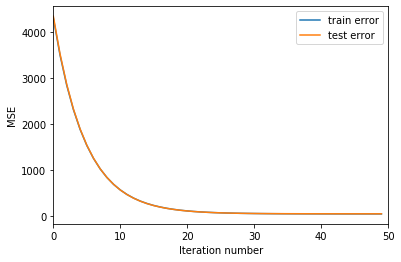

In [61]:
get_error_plot(n_trees, train_errors, test_errors)

In [62]:
%%time
#тренировочный набор
y_train_pred = gb_predict(X_train, trees, coefs, eta)
y_test_pred = gb_predict(X_test, trees, coefs, eta)
r2_score(y_train, y_train_pred),r2_score(y_test, y_test_pred)
#(0.7953320215816231, 0.7687612786731939)

Wall time: 3.41 s


(0.7901817078304285, 0.7847341793032637)

In [63]:
%%time
#финальный набор test, который нужно посчитать
X_submission = np.array(calc_norm_fit(test[features]))# отбираем множество признаков и нормализуем
y_submission_pred = gb_predict(X_submission, trees, coefs, eta)
y_submission_pred

Wall time: 3.93 s


array([54.87319342, 65.13292245, 47.42959137, ..., 54.52498689,
       64.88460299, 68.48128754])

In [64]:
df = pd.DataFrame(y_submission_pred)
df.columns = ['mean_exam_points']
df['Id'] = range(10000,len(df)+10000)
df_save = df[['Id','mean_exam_points']]
SAVE_TO_FILE(df_save,'gb-50-3-0.1--min_leaf_100', PATH_FOLDER)

Видим, что качество обучения улучшается.

__ВЫВОД:__
В целом, тут мы показали, что варьируя параметры обучения градиентного бустинга можно добиваться различного уровня точности модели. Наиболее интересным в плане прогресса наблюдением стало изменение параметра дерева(!) min_leaf от исходного 5 до 50, 100
при сохранении числа деревьев 50 и глубины 3, eta = 0.1

__ЭКСПЕРИМЕНТ:__
Уменьшим шаг до 0.01.

In [192]:
#также попробуем обработать выбросы
# интерквартильный размах
list = ['lesson_price','age']
print('processing dataframe train')
IQ_processing(train, list)
print('processing dataframe test')
IQ_processing(test, list)

processing dataframe train
lesson_price {'IQ': 850.0, 'low_border': 25.0, 'high_border': 3425.0, 'count': 25, 'median': 1500.0}
count after procesing: 0
age {'IQ': 11.0, 'low_border': 23.5, 'high_border': 67.5, 'count': 77, 'median': 46.0}
count after procesing: 0
processing dataframe test
lesson_price {'IQ': 850.0, 'low_border': 25.0, 'high_border': 3425.0, 'count': 16, 'median': 1500.0}
count after procesing: 0
age {'IQ': 10.0, 'low_border': 26.0, 'high_border': 66.0, 'count': 100, 'median': 46.0}
count after procesing: 0


In [193]:
X = np.array(calc_norm_fit(train[features]))# отбираем множество признаков и нормализуем
#train_f = calc_std_fit(train[features])# отбираем множество признаков и стандартизируем
y = np.array(train['mean_exam_points'])

In [194]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)

In [76]:
%%time
eta = 0.01
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

Wall time: 6min 14s


In [77]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.01 на тренировочной выборке: 1601.159142951112
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 1618.4865269495112


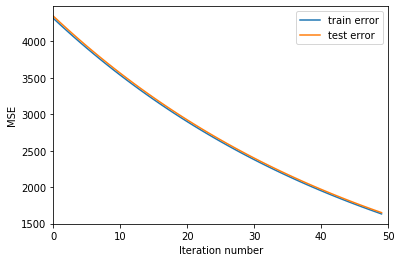

In [78]:
get_error_plot(n_trees, train_errors, test_errors)

При таком размере шага алгоритм сходится, но ему для достижения удовлетворительных показателей требуется большее количество итераций.